In [1]:
## imports
import numpy as np
from matplotlib import pyplot as plt
from struct import unpack
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import modeling
import time
import numpy.matlib
%matplotlib widget

In [2]:
lines_of_data = 512

filename = 'C:/SPAD_ARRAY/release_2208/mainstream/Data/11-4-2022/acq_221104_10'

In [3]:
# Read data file 
# data used from picosecond laser
st = time.time()

rawFile = np.fromfile(filename, dtype=np.uint32)  # read data 
data = (rawFile & 0xFFFFFFF).astype(np.longlong)*17.857 # Multiply with the lowes bin
data[np.where(rawFile < 0x80000000)] = -1 # Mask not valid data 
nmrCycles = int(len(data) / lines_of_data / 256)  # number of cycles,
data_matrix = data.reshape((lines_of_data,nmrCycles*256), order='F').reshape((lines_of_data, 256,-1),order='F').transpose((0,2,1)).reshape((-1, 256),order='F').transpose() # reshape the matrix
    
et = time.time()
print('Execution time:', et - st, 'seconds')

Execution time: 0.035007476806640625 seconds


In [4]:
# creates a list of arrays that contains positions of coincident peaks 
# with pixels 0 and 1-63; then 1 and 2-63 

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
pixel_combinations = []
peak_positions = [[],[],[],[]]
print(time.ctime())

k = 0
while k < 4:
    print(k,time.ctime())
    for j in range(0+64*k,2+64*k):
        for i in range(0+64*k,64+64*k):
            if j < i:
                #print(i,time.ctime())
                p0 = j
                p1 = i

                pixel_0 = data_matrix[p0]
                pixel_1 = data_matrix[p1]

                timewindow = 30000
                timestampsnmr = lines_of_data
                nmr_of_cycles = int(len(pixel_0) / timestampsnmr)
                delta_t = []

                # start = time.time()
                for cycle in range(nmr_of_cycles):
                    for timestamp_pix0 in range(timestampsnmr):
                        pix_0 = pixel_0[cycle * timestampsnmr + timestamp_pix0]
                        if pix_0 == -1:
                            break
                        for timestamp_pix1 in range(timestampsnmr):
                            pix_1=pixel_1[cycle * timestampsnmr + timestamp_pix1]
                            if pix_1 == -1 or pix_1 == 0:
                                break
                            if np.abs(pix_0 - pix_1) < timewindow:
                                delta_t.append(pix_0 - pix_1)
                            else:
                                continue
                #print(len(delta_t))
                bins = np.arange(np.min(delta_t), np.max(delta_t), 17.857)

                counts, binEdges=np.histogram(delta_t,bins=bins)
                binCenters = 0.5*(binEdges[1:]+binEdges[:-1])

                n_max = np.argmax(counts)
                arg_max = (binEdges[n_max] + binEdges[n_max + 1]) / 2
                sigma = 200

                parameters, covariance = curve_fit(gauss, binCenters, counts,p0=[max(counts), arg_max, sigma])

                fit_y = gauss(binCenters, parameters[0], parameters[1], parameters[2])

                peak_positions[k] = np.concatenate((peak_positions[k], parameters[1]),axis=None)
                #pixel_combinations = np.concatenate((pixel_combinations, str(j)+','+str(i)),axis=None)
            else:
                pass
    k += 1
    if k == 4:
        break
print(time.ctime())

Mon Nov 28 13:29:27 2022
0 Mon Nov 28 13:29:27 2022
1 Mon Nov 28 13:30:03 2022
2 Mon Nov 28 13:31:52 2022
3 Mon Nov 28 13:37:45 2022
Mon Nov 28 13:39:54 2022


In [37]:
print(peak_positions)

[array([ 2.12383820e+03, -3.97020970e+02,  1.81892386e+03, -1.61417654e+03,
       -5.61067023e+03, -2.99827274e+03, -2.41698587e+03, -3.22184203e+03,
        4.92629170e+00, -5.03927563e+03, -4.26146649e+03,  2.77196609e+03,
       -2.71529592e+03, -1.90386743e+03, -1.93292567e+03, -2.23907684e+03,
       -5.26918576e+03,  3.23569428e+03, -1.39974557e+03, -4.63402439e+02,
        2.00031982e+03, -1.99731624e+03, -1.21790540e+03,  6.59757230e+02,
       -4.60724735e+03, -1.43880905e+03,  9.81257212e+01, -1.60425503e+03,
       -7.01628660e+02, -1.68220991e+03,  9.77706821e+02, -2.27503404e+03,
        2.43847184e+03, -2.89537392e+03, -1.90232985e+03,  3.18244609e+01,
        1.54882100e+03, -4.99727230e+03, -1.52146224e+03, -1.84222992e+03,
       -3.39431834e+03, -3.12539838e+03, -1.17372098e+03, -1.48227129e+02,
       -7.01198952e+02, -2.16131170e+03, -4.45432477e+03, -8.30711603e+02,
       -7.49804218e+03, -1.08743327e+03, -5.52689157e+02, -2.55930296e+03,
       -4.12018360e+03, 

In [88]:
# changes value to 0 at position 64, 
# for equation 64 below
peak_positions = peak_positions
for i in range(0,4):
    peak_positions[i][64] = 0
print(peak_positions)

[array([ 2.12383820e+03, -3.97020970e+02,  1.81892386e+03, -1.61417654e+03,
       -5.61067023e+03, -2.99827274e+03, -2.41698587e+03, -3.22184203e+03,
        4.92629170e+00, -5.03927563e+03, -4.26146649e+03,  2.77196609e+03,
       -2.71529592e+03, -1.90386743e+03, -1.93292567e+03, -2.23907684e+03,
       -5.26918576e+03,  3.23569428e+03, -1.39974557e+03, -4.63402439e+02,
        2.00031982e+03, -1.99731624e+03, -1.21790540e+03,  6.59757230e+02,
       -4.60724735e+03, -1.43880905e+03,  9.81257212e+01, -1.60425503e+03,
       -7.01628660e+02, -1.68220991e+03,  9.77706821e+02, -2.27503404e+03,
        2.43847184e+03, -2.89537392e+03, -1.90232985e+03,  3.18244609e+01,
        1.54882100e+03, -4.99727230e+03, -1.52146224e+03, -1.84222992e+03,
       -3.39431834e+03, -3.12539838e+03, -1.17372098e+03, -1.48227129e+02,
       -7.01198952e+02, -2.16131170e+03, -4.45432477e+03, -8.30711603e+02,
       -7.49804218e+03, -1.08743327e+03, -5.52689157e+02, -2.55930296e+03,
       -4.12018360e+03, 

In [89]:
# creates matrix for system of equations
a = np.zeros((64,64))
for i in range(0,63):
    a[i][0] = 1
    a[i][i+1] = -1
    #a[i][:i+2:i+1] = 1
    #a[-1][1:3] = 1
    a[-1] = 1
    #a[-1][1] = 1
    #a[-1][2] = 1

In [90]:
print(a)

[[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 1.  0.  0. ...  0. -1.  0.]
 [ 1.  0.  0. ...  0.  0. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]]


In [91]:
# calculates offsets of each pixel
offsets_arr = []
for i in range(0,4):
    offsets = np.linalg.solve(a,peak_positions[i][:64])
    offsets_arr = np.concatenate((offsets_arr,offsets),axis=None)
print(offsets_arr)

[-1674.0000263  -3797.83822889 -1276.97905607 -3492.92388878
   -59.82348868  3936.6702047   1324.27271547   742.9858436
  1547.84200529 -1678.92631799  3365.27560495  2587.46646631
 -4445.96611454  1041.29589819   229.86740312   258.9256483
   565.0768158   3595.18573286 -4909.69430332  -274.25445695
 -1210.59758712 -3674.31984239   323.31621862  -456.09462147
 -2333.75725639  2933.24731899  -235.1909735  -1772.12574753
   -69.74499744  -972.37136649     8.20988414 -2651.70684697
   601.03401328 -4112.47186229  1221.3738924    228.32982356
 -1705.82448719 -3222.82102982  3323.27227506  -152.53778922
   168.22989391  1720.3183128   1451.39835352  -500.27904944
 -1525.77289688  -972.80107401   487.31167112  2780.32474397
  -843.2884231   5824.04215321  -586.56675407 -1121.31086952
   885.3029326   2446.18357322  2173.7856818   3041.57369702
 -3200.34895385 -1513.82176056 -1359.71347706  2949.03466149
  2009.83038354     9.28725699 -1852.74426645  1365.26011615
  1852.89907946 -3152.2541

In [95]:
offsets_arr = np.asarray(offsets_arr)
print(np.average(offsets_arr))

2.444326629247975


In [96]:
# saves array of pixel offsets
np.save('offsets_arr.npy',offsets_arr)

In [4]:
offsets_arr = np.load('offsets_arr.npy')
print(offsets_arr)

[-1674.0000263  -3797.83822889 -1276.97905607 -3492.92388878
   -59.82348868  3936.6702047   1324.27271547   742.9858436
  1547.84200529 -1678.92631799  3365.27560495  2587.46646631
 -4445.96611454  1041.29589819   229.86740312   258.9256483
   565.0768158   3595.18573286 -4909.69430332  -274.25445695
 -1210.59758712 -3674.31984239   323.31621862  -456.09462147
 -2333.75725639  2933.24731899  -235.1909735  -1772.12574753
   -69.74499744  -972.37136649     8.20988414 -2651.70684697
   601.03401328 -4112.47186229  1221.3738924    228.32982356
 -1705.82448719 -3222.82102982  3323.27227506  -152.53778922
   168.22989391  1720.3183128   1451.39835352  -500.27904944
 -1525.77289688  -972.80107401   487.31167112  2780.32474397
  -843.2884231   5824.04215321  -586.56675407 -1121.31086952
   885.3029326   2446.18357322  2173.7856818   3041.57369702
 -3200.34895385 -1513.82176056 -1359.71347706  2949.03466149
  2009.83038354     9.28725699 -1852.74426645  1365.26011615
  1852.89907946 -3152.2541

In [10]:
## Compute delta t for two pixels 

# Set peak postion

p0 = 23
p1 = 40

pixel_0 = data_matrix[p0]
pixel_1 = data_matrix[p1]

ind = np.argwhere(pixel_0 >= 0)
pixel_0[ind] = pixel_0[ind] - offsets_arr[p0]

ind = np.argwhere(pixel_1 >= 0)
pixel_1[ind] = pixel_1[ind] - offsets_arr[p1]

timewindow = 30000
timestampsnmr = lines_of_data
nmr_of_cycles = int(len(pixel_0) / timestampsnmr)
delta_t = []

# start = time.time()
for cycle in range(nmr_of_cycles):
    for timestamp_pix0 in range(timestampsnmr):
        pix_0 = pixel_0[cycle * timestampsnmr + timestamp_pix0]
        if pix_0 == -1:
            break
        for timestamp_pix1 in range(timestampsnmr):
            pix_1=pixel_1[cycle * timestampsnmr + timestamp_pix1] 
            if pix_1 == -1 or pix_1 == 0:
                break
            if np.abs(pix_0 - pix_1) < timewindow:
                delta_t.append(pix_0 - pix_1)
            else:
                continue

NMR of coincidences in window: 125


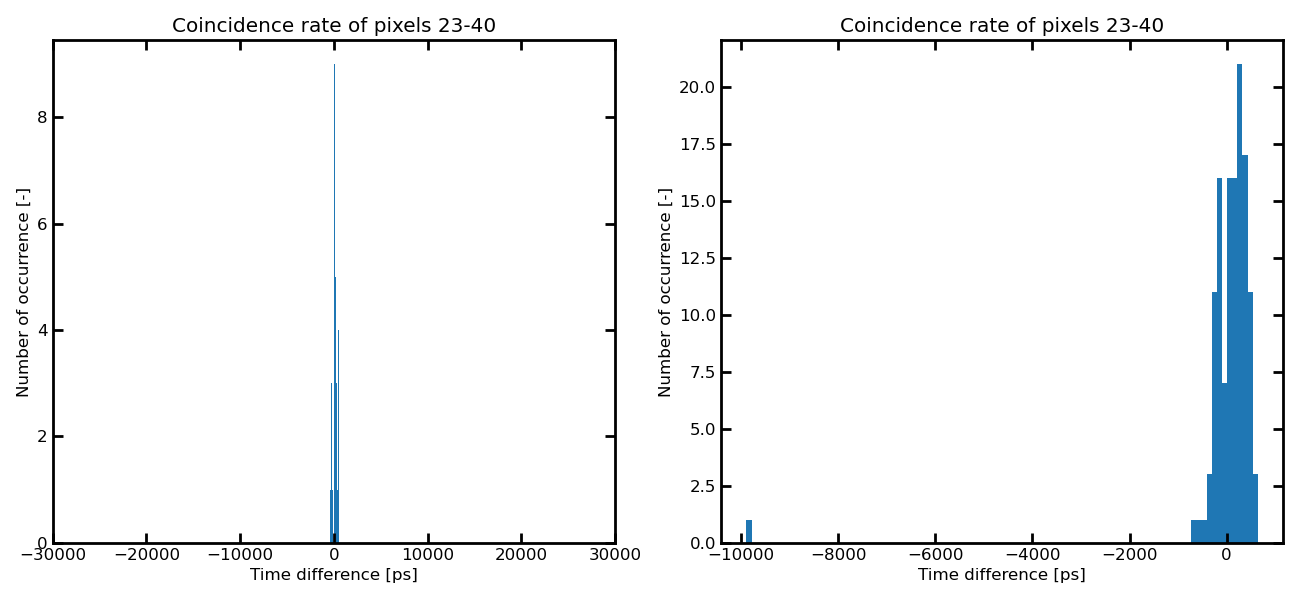

In [11]:
fig, ax = plt.subplots(1,2,figsize=(8,10))

plt.rcParams.update({"font.size": 12})
x = np.arange(0, 256, 1)

plt.xlabel("Pixel [-]")
plt.ylabel("Valid timestamps [-]")

plt.box(bool(1))
plt.grid(False)
plt.subplots_adjust(left=0.15)
fig.set_size_inches(13, 6)

for i in range(2):
    ax[i].tick_params(which="both", width=2, direction="in")
    ax[i].tick_params(which="major", length=7, direction="in")
    ax[i].tick_params(which="minor", length=4, direction="in")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")
    ax[i].set_xlabel("Time difference [ps]")
    ax[i].set_ylabel("Number of occurrence [-]")
    ax[i].set_title("Coincidence rate of pixels {}-{}".format(p0,p1))
    
for axis in ["top", "bottom", "left", "right"]:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)

bins = np.arange(np.min(delta_t), np.max(delta_t), 17.857) #
bins = 100
bins2 = np.arange(np.min(delta_t), np.max(delta_t), 50 )
ax[0].hist(delta_t, bins=500)
ax[1].hist(delta_t, bins=bins)
ax[0].set_xlim(-timewindow, timewindow)

# Set limits of right plot
#ax[1].set_xlim(-4500, -4400)

fig.tight_layout(pad=1.0)

print("NMR of coincidences in window: " + str(len(delta_t)))

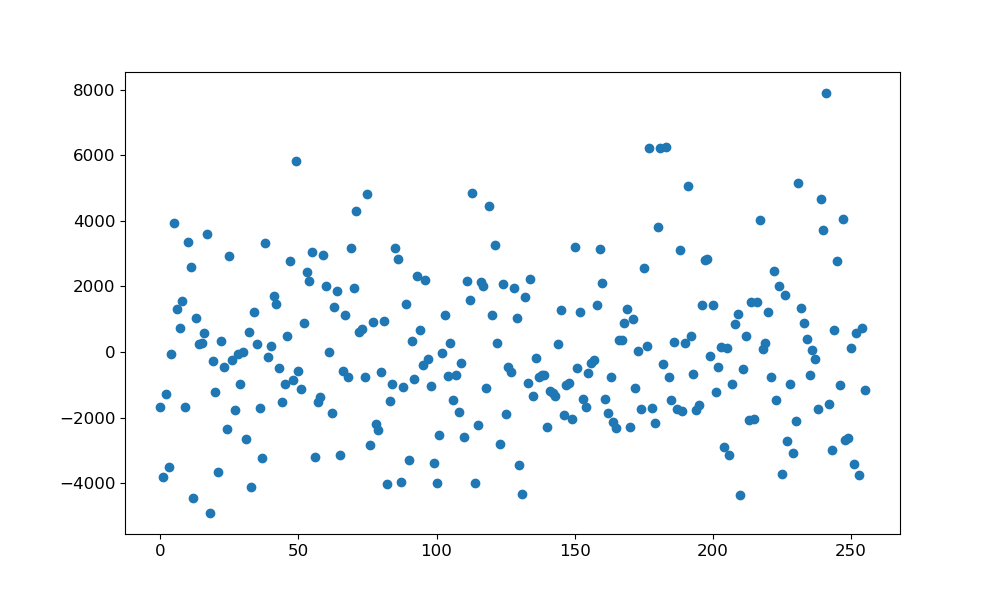

In [7]:
x_axis = np.arange(256)
fig,ax = plt.subplots(figsize = (10,6))
ax.scatter(x_axis,offsets_arr)